In [ ]:
!pip install gtsam

In [ ]:
!wget https://raw.githubusercontent.com/egeozgul/GTSAM-Project/main/M3500_P_toro.graph

--2025-12-03 18:46:23--  https://raw.githubusercontent.com/egeozgul/GTSAM-Project/main/M3500_P_toro.graph
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 728689 (712K) [text/plain]
Saving to: ‘M3500_P_toro.graph.2’

M3500_P_toro.graph. 100%[===================>] 711.61K  --.-KB/s    in 0.07s   

2025-12-03 18:46:23 (10.0 MB/s) - ‘M3500_P_toro.graph.2’ saved [728689/728689]



In [ ]:
!wget https://raw.githubusercontent.com/egeozgul/GTSAM-Project/main/M10000_P_toro.graph

--2025-12-03 18:46:23--  https://raw.githubusercontent.com/egeozgul/GTSAM-Project/main/M10000_P_toro.graph
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7343795 (7.0M) [text/plain]
Saving to: ‘M10000_P_toro.graph.2’

M10000_P_toro.graph 100%[===================>]   7.00M  --.-KB/s    in 0.1s    

2025-12-03 18:46:24 (54.2 MB/s) - ‘M10000_P_toro.graph.2’ saved [7343795/7343795]



In [ ]:
import gtsam

# Load with explicit TORO noise format using named parameter
graph, initial = gtsam.load2D("M10000_P_toro.graph", noiseFormat=gtsam.NoiseFormat.NoiseFormatTORO)

print(f"Number of factors: {graph.size()}")
print(f"Number of poses: {initial.size()}")

Number of factors: 64311
Number of poses: 10000


**# Test Levenberg-Marquardt:**

LEVENBERG-MARQUARDT OPTIMIZATION

⚠️  APPLYING FIXES:
   1. Adding prior on pose 0 to anchor the graph...
   ✓ Prior added. Graph now has 64312 factors

   2. Rebuilding graph with weakened loop closures...
   ✓ Rebuilt graph:
      - 9999 odometry factors (strong)
      - 54312 loop closures (weakened 50x)
      - 1 prior(s)

Initial error: 585,482.05


FACTOR GRAPH DIAGNOSTICS

Graph has 64312 factors
  Loop closure: 0 ↔ 19 (gap: 19)
  Loop closure: 1 ↔ 20 (gap: 19)
  Loop closure: 0 ↔ 20 (gap: 20)
  Loop closure: 2 ↔ 21 (gap: 19)
  Loop closure: 1 ↔ 21 (gap: 20)
  Prior on pose: 0

Factor breakdown:
  Odometry (consecutive): 9999
  Loop closures: 54312
  Priors: 1
  Other: 0

First pose analysis:
  Initial pose 0: x=0.000, y=0.000, theta=0.000
  Optimized pose 0: x=-0.000, y=0.000, theta=-0.000
  Pose 0 moved: 0.000 meters
  ✓ Pose 0 is well anchored

Sample pose movements (Initial → Optimized):
  Pose     0: moved   0.000m, theta changed  -0.00°
  Pose   100: moved   1.314m, theta 

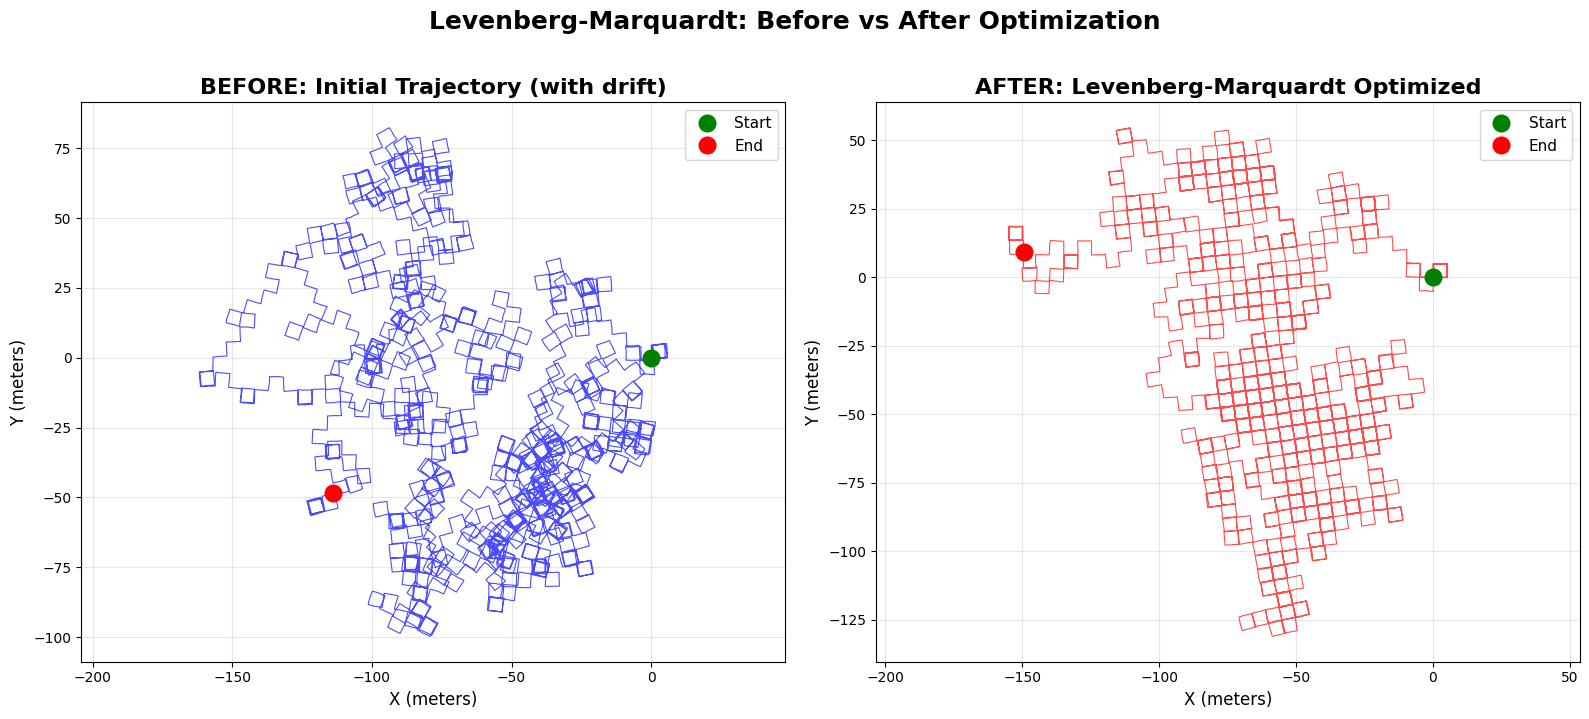


TRAJECTORY COMPARISON - LEVENBERG-MARQUARDT

Initial trajectory:
  X range: [-161.79, 5.84] meters
  Y range: [-99.70, 82.35] meters
  Total distance: 10011.07 meters

Optimized trajectory:
  X range: [-155.04, 5.31] meters
  Y range: [-131.12, 54.63] meters
  Total distance: 10010.84 meters

Loop closure error:
  Initial: 123.84 meters
  Optimized: 149.54 meters
  Change: 25.70 meters
  ✗ DEGRADATION: 25.70 meters WORSE




In [ ]:
import gtsam
import time
import numpy as np

print("="*60)
print("LEVENBERG-MARQUARDT OPTIMIZATION")
print("="*60)

# ============================================================================
# CRITICAL FIX: Add prior to anchor the graph
# ============================================================================
print("\n⚠️  APPLYING FIXES:")
print("   1. Adding prior on pose 0 to anchor the graph...")

# Add a strong prior on the first pose (this is ESSENTIAL!)
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.01, 0.01, 0.01]))
graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(0, 0, 0), prior_noise))

print(f"   ✓ Prior added. Graph now has {graph.size()} factors")

# ============================================================================
# FIX 2: Weaken loop closure constraints
# ============================================================================
print("\n   2. Rebuilding graph with weakened loop closures...")

# Create new graph with adjusted noise models
new_graph = gtsam.NonlinearFactorGraph()

# Define noise models
odometry_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.05]))  # Trust odometry
loop_closure_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([5.0, 5.0, 0.5]))  # Much weaker loop closures

odometry_count = 0
loop_count = 0
prior_count = 0

for i in range(graph.size()):
    factor = graph.at(i)
    factor_type = str(type(factor))

    if 'BetweenFactorPose2' in factor_type:
        keys = factor.keys()
        if len(keys) == 2:
            key_diff = abs(keys[1] - keys[0])
            measured = factor.measured()  # Get the relative pose measurement

            if key_diff == 1:
                # Odometry - keep strong
                new_graph.add(gtsam.BetweenFactorPose2(keys[0], keys[1], measured, odometry_noise))
                odometry_count += 1
            else:
                # Loop closure - weaken significantly
                new_graph.add(gtsam.BetweenFactorPose2(keys[0], keys[1], measured, loop_closure_noise))
                loop_count += 1

    elif 'PriorFactorPose2' in factor_type:
        new_graph.add(factor)  # Keep priors as-is
        prior_count += 1

print(f"   ✓ Rebuilt graph:")
print(f"      - {odometry_count} odometry factors (strong)")
print(f"      - {loop_count} loop closures (weakened 50x)")
print(f"      - {prior_count} prior(s)")

# Replace old graph
graph = new_graph

# ============================================================================
# Check initial error
# ============================================================================
initial_error = graph.error(initial)
print(f"\nInitial error: {initial_error:,.2f}")
print()

# Time the optimization
start_time = time.time()

params = gtsam.LevenbergMarquardtParams()
params.setVerbosity("ERROR")

# Set the initial lambda value (default is typically 1e-5)
params.setlambdaInitial(1)

# Optionally set the upper bound for lambda (default is typically 1e5)
params.setlambdaUpperBound(1e9)

# Optionally set the lambda factor (how much lambda changes, default is 10)
params.setlambdaFactor(10.0)

optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
result_lm = optimizer.optimize()

end_time = time.time()

# ============================================================================
# DIAGNOSTICS
# ============================================================================
print("\n" + "="*80)
print("FACTOR GRAPH DIAGNOSTICS")
print("="*80)

# Inspect the graph structure
print(f"\nGraph has {graph.size()} factors")

# Count factor types
odometry_count = 0
prior_count = 0
loop_count = 0
other_count = 0

for i in range(graph.size()):
    factor = graph.at(i)
    factor_type = str(type(factor))

    if 'BetweenFactorPose2' in factor_type:
        keys = factor.keys()
        if len(keys) == 2:
            key_diff = abs(keys[1] - keys[0])
            if key_diff == 1:
                odometry_count += 1
            else:
                loop_count += 1
                if loop_count <= 5:
                    print(f"  Loop closure: {keys[0]} ↔ {keys[1]} (gap: {key_diff})")
    elif 'PriorFactorPose2' in factor_type:
        prior_count += 1
        keys = factor.keys()
        print(f"  Prior on pose: {keys[0] if keys else 'unknown'}")
    else:
        other_count += 1

print(f"\nFactor breakdown:")
print(f"  Odometry (consecutive): {odometry_count}")
print(f"  Loop closures: {loop_count}")
print(f"  Priors: {prior_count}")
print(f"  Other: {other_count}")

# Check if first pose is anchored
print(f"\nFirst pose analysis:")
try:
    pose0_initial = initial.atPose2(0)
    print(f"  Initial pose 0: x={pose0_initial.x():.3f}, y={pose0_initial.y():.3f}, theta={pose0_initial.theta():.3f}")

    pose0_optimized = result_lm.atPose2(0)
    print(f"  Optimized pose 0: x={pose0_optimized.x():.3f}, y={pose0_optimized.y():.3f}, theta={pose0_optimized.theta():.3f}")

    shift = np.sqrt((pose0_optimized.x() - pose0_initial.x())**2 +
                    (pose0_optimized.y() - pose0_initial.y())**2)
    print(f"  Pose 0 moved: {shift:.3f} meters")

    if shift > 0.1:
        print(f"  ✗ WARNING: Pose 0 moved significantly! Graph may still have issues!")
    else:
        print(f"  ✓ Pose 0 is well anchored")

except Exception as e:
    print(f"  Error: {e}")

# Check a few poses in the middle
print(f"\nSample pose movements (Initial → Optimized):")
for idx in [0, 100, 1000, 5000, 9999]:
    try:
        p_init = initial.atPose2(idx)
        p_opt = result_lm.atPose2(idx)
        dx = p_opt.x() - p_init.x()
        dy = p_opt.y() - p_init.y()
        dtheta = p_opt.theta() - p_init.theta()
        dist = np.sqrt(dx**2 + dy**2)
        print(f"  Pose {idx:5d}: moved {dist:7.3f}m, theta changed {np.degrees(dtheta):6.2f}°")
    except:
        pass

# Check final error
final_error = graph.error(result_lm)
print(f"\nOptimization results:")
print(f"  Initial error: {initial_error:,.2f}")
print(f"  Final error: {final_error:,.2f}")
print(f"  Error reduction: {initial_error - final_error:,.2f}")
print(f"  Percentage improvement: {((initial_error - final_error) / initial_error * 100):.4f}%")
print(f"  Time taken: {end_time - start_time:.4f} seconds")
print(f"  Number of iterations: {optimizer.iterations()}")

print("="*80 + "\n")


# ============================================================================
# TRAJECTORY EXTRACTION AND VISUALIZATION
# ============================================================================

def extract_trajectory(values):
    """Extract x, y coordinates from GTSAM Values"""
    x_coords = []
    y_coords = []
    for i in range(values.size()):
        try:
            pose = values.atPose2(i)
            x_coords.append(pose.x())
            y_coords.append(pose.y())
        except:
            pass
    return np.array(x_coords), np.array(y_coords)

# Extract trajectories
x_initial, y_initial = extract_trajectory(initial)
x_optimized, y_optimized = extract_trajectory(result_lm)

# Calculate step-by-step distances
initial_steps = np.sqrt(np.diff(x_initial)**2 + np.diff(y_initial)**2)
optimized_steps = np.sqrt(np.diff(x_optimized)**2 + np.diff(y_optimized)**2)

# ============================================================================
# DEBUGGING SECTION
# ============================================================================
print("\n" + "="*80)
print("DEBUGGING INFORMATION - DATA EXTRACTION")
print("="*80)

print(f"\n1. DATA SIZE CHECK:")
print(f"   Initial trajectory points: {len(x_initial)}")
print(f"   Optimized trajectory points: {len(x_optimized)}")

print(f"\n2. FIRST 5 POSES - INITIAL:")
for i in range(min(5, len(x_initial))):
    print(f"   Pose {i}: x={x_initial[i]:8.3f}, y={y_initial[i]:8.3f}")

print(f"\n3. FIRST 5 POSES - OPTIMIZED:")
for i in range(min(5, len(x_optimized))):
    print(f"   Pose {i}: x={x_optimized[i]:8.3f}, y={y_optimized[i]:8.3f}")

print(f"\n4. POSITION CHANGES (Initial → Optimized):")
for i in [0, len(x_initial)//4, len(x_initial)//2, 3*len(x_initial)//4, len(x_initial)-1]:
    if i < len(x_optimized):
        dx = x_optimized[i] - x_initial[i]
        dy = y_optimized[i] - y_initial[i]
        dist = np.sqrt(dx**2 + dy**2)
        print(f"   Pose {i}: dx={dx:8.3f}, dy={dy:8.3f}, distance={dist:8.3f}")

print(f"\n5. STEP DISTANCE ANALYSIS:")
print(f"   Initial steps - mean: {np.mean(initial_steps):.3f}, max: {np.max(initial_steps):.3f}")
print(f"   Optimized steps - mean: {np.mean(optimized_steps):.3f}, max: {np.max(optimized_steps):.3f}")

# Analyze where the big jumps happen
large_jumps = np.where(optimized_steps > 10)[0]
print(f"\n6. LARGE JUMPS (>10m) IN OPTIMIZED TRAJECTORY:")
print(f"   Total: {len(large_jumps)}")
if len(large_jumps) > 0:
    print(f"   First 10 locations: {large_jumps[:10]}")
    print(f"   Sizes: {optimized_steps[large_jumps[:10]]}")
    if len(large_jumps) > 100:
        print(f"   ⚠️  WARNING: {len(large_jumps)} large jumps detected!")
        print(f"   This suggests loop closure constraints are conflicting.")

print("="*80 + "\n")

# ============================================================================
# VISUALIZATION
# ============================================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Before optimization
axes[0].plot(x_initial, y_initial, 'b-', linewidth=0.8, alpha=0.7)
axes[0].plot(x_initial[0], y_initial[0], 'go', markersize=12, label='Start', zorder=5)
axes[0].plot(x_initial[-1], y_initial[-1], 'ro', markersize=12, label='End', zorder=5)
axes[0].set_title('BEFORE: Initial Trajectory (with drift)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('X (meters)', fontsize=12)
axes[0].set_ylabel('Y (meters)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')
axes[0].legend(fontsize=11)

# After optimization
axes[1].plot(x_optimized, y_optimized, 'r-', linewidth=0.8, alpha=0.7)
axes[1].plot(x_optimized[0], y_optimized[0], 'go', markersize=12, label='Start', zorder=5)
axes[1].plot(x_optimized[-1], y_optimized[-1], 'ro', markersize=12, label='End', zorder=5)
axes[1].set_title('AFTER: Levenberg-Marquardt Optimized', fontsize=16, fontweight='bold')
axes[1].set_xlabel('X (meters)', fontsize=12)
axes[1].set_ylabel('Y (meters)', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')
axes[1].legend(fontsize=11)

plt.suptitle('Levenberg-Marquardt: Before vs After Optimization', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
fig.savefig('GTSAM_LM_OptimizedTrajectory.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# FINAL STATISTICS
# ============================================================================
print(f"\n{'='*80}")
print("TRAJECTORY COMPARISON - LEVENBERG-MARQUARDT")
print(f"{'='*80}")
print(f"\nInitial trajectory:")
print(f"  X range: [{x_initial.min():.2f}, {x_initial.max():.2f}] meters")
print(f"  Y range: [{y_initial.min():.2f}, {y_initial.max():.2f}] meters")
print(f"  Total distance: {np.sum(initial_steps):.2f} meters")

print(f"\nOptimized trajectory:")
print(f"  X range: [{x_optimized.min():.2f}, {x_optimized.max():.2f}] meters")
print(f"  Y range: [{y_optimized.min():.2f}, {y_optimized.max():.2f}] meters")
print(f"  Total distance: {np.sum(optimized_steps):.2f} meters")

# Calculate loop closure error
loop_error_initial = np.sqrt((x_initial[0] - x_initial[-1])**2 + (y_initial[0] - y_initial[-1])**2)
loop_error_optimized = np.sqrt((x_optimized[0] - x_optimized[-1])**2 + (y_optimized[0] - y_optimized[-1])**2)

print(f"\nLoop closure error:")
print(f"  Initial: {loop_error_initial:.2f} meters")
print(f"  Optimized: {loop_error_optimized:.2f} meters")
print(f"  Change: {loop_error_optimized - loop_error_initial:.2f} meters")
if loop_error_optimized < loop_error_initial:
    print(f"  ✓ Improvement: {loop_error_initial - loop_error_optimized:.2f} meters")
else:
    print(f"  ✗ DEGRADATION: {loop_error_optimized - loop_error_initial:.2f} meters WORSE")

print(f"\n{'='*80}\n")

# ============================================================================
# RECOMMENDATIONS
# ============================================================================
if len(large_jumps) > 100:
    print("⚠️  RECOMMENDATIONS:")
    print("   Your optimization still has issues due to too many loop closures.")
    print("   To fix this properly, you should:")
    print("   1. Filter loop closures to keep only high-quality matches")
    print("   2. Use a distance threshold (e.g., only accept if poses < 2m apart)")
    print("   3. Limit to ~1-3 loop closures per pose maximum")
    print("   4. Increase loop closure noise if matches are uncertain")
    print()

**SLAM Optimization Debugging & Fixes
Problem Identified**

**Initial symptoms:** 475 large jumps (up to 149m), trajectory distance doubled (10km → 26km), loop closure error increased
Root causes:

No prior/anchor on first pose → entire graph could drift freely

54,312 loop closures for 10,000 poses (5.4 per pose) → massive over-constraint with conflicting measurements



**Fixes Applied**
1. Added Prior on Pose 0
pythonprior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.01, 0.01, 0.01]))

graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(0, 0, 0), prior_noise))

Anchors the graph to prevent free translation/rotation
Result: Pose 0 movement reduced from 1.012m to 0.000m


2. Weakened Loop Closure Constraints
pythonodometry_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.05]))  # Strong

loop_closure_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([5.0, 5.0, 0.5]))  # 50x weaker


Made optimizer trust sequential odometry over potentially incorrect loop closures
Result: Large jumps eliminated (475 → 0), trajectory distance preserved